In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import igraph as ig
import tqdm

In [3]:
import os
import sys

sys.path.append('../')

In [4]:
ROOT = os.getcwd()
WORK_DIR = os.path.dirname(os.path.dirname(ROOT))

## ***Data Ingestion***

In [5]:
df_classes = pl.read_csv(os.path.join(WORK_DIR, 'data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv'), new_columns=['transid', 'class'])
df_edgelist = pl.read_csv(os.path.join(WORK_DIR, 'data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv'), new_columns=['current_transid', 'next_transid'])
df_features = pl.read_csv(os.path.join(WORK_DIR, 'data/elliptic_bitcoin_dataset/elliptic_txs_features.csv'), has_header=False)

In [9]:
first_feat_name = {
    'column_1': 'transid',
    'column_2': 'time_steps',
}

second_feat_name = {f'column_{i}': f'feature_{i-2}' for i in range(3, df_features.shape[1] + 1)}

converted_feature_names = {**first_feat_name, **second_feat_name}

In [10]:
df_features = df_features.rename(converted_feature_names)

In [11]:
df = df_features.join(df_classes, on='transid', how='left')

In [13]:
df

shape: (203_769, 168)
┌───────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬─────────┐
│ transid   ┆ time_steps ┆ feature_1 ┆ feature_2 ┆ … ┆ feature_1 ┆ feature_1 ┆ feature_1 ┆ class   │
│ ---       ┆ ---        ┆ ---       ┆ ---       ┆   ┆ 63        ┆ 64        ┆ 65        ┆ ---     │
│ i64       ┆ i64        ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str     │
│           ┆            ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆         │
╞═══════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═════════╡
│ 230425980 ┆ 1          ┆ -0.171469 ┆ -0.184668 ┆ … ┆ -0.097524 ┆ -0.120613 ┆ -0.119792 ┆ unknown │
│ 5530458   ┆ 1          ┆ -0.171484 ┆ -0.184668 ┆ … ┆ -0.097524 ┆ -0.120613 ┆ -0.119792 ┆ unknown │
│ 232022460 ┆ 1          ┆ -0.172107 ┆ -0.184668 ┆ … ┆ -0.183671 ┆ -0.120613 ┆ -0.119792 ┆ unknown │
│ 232438397 ┆ 1          ┆ 0.163054  ┆ 1.96379   ┆ … ┆ 0.677799  ┆ -0.120613 ┆ -0.119792 ┆ 2       │
│ 230460314 ┆ 1          ┆ 1.011523  ┆ -0.081127 ┆ … ┆ 1.29375   ┆ 0.178136  ┆ 0.179117  ┆ unknown │
│ …         ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …       │
│ 173077460 ┆ 49         ┆ -0.145771 ┆ -0.163752 ┆ … ┆ -0.097524 ┆ -0.120613 ┆ -0.119792 ┆ unknown │
│ 158577750 ┆ 49         ┆ -0.16592  ┆ -0.123607 ┆ … ┆ -0.140597 ┆ -1.760926 ┆ -1.760984 ┆ unknown │
│ 158375402 ┆ 49         ┆ -0.172014 ┆ -0.078182 ┆ … ┆ -0.097524 ┆ -0.120613 ┆ -0.119792 ┆ 1       │
│ 158654197 ┆ 49         ┆ -0.172842 ┆ -0.176622 ┆ … ┆ -0.140597 ┆ 1.5197    ┆ 1.521399  ┆ unknown │
│ 157597225 ┆ 49         ┆ -0.012037 ┆ -0.132276 ┆ … ┆ -0.140597 ┆ 1.5197    ┆ 1.521399  ┆ unknown │
└───────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴─────────┘

In [12]:
def convert_df_features(df: pl.DataFrame) -> pl.DataFrame:

    df = df.with_columns(
        pl.struct(df.columns[2:-1]).apply(lambda row: list(row.values())).alias('features')
    ).drop(df.columns[2:-1])
    
    return df

## ***Prepare train/val/test set***

In [12]:
mapping = {'unknown': 2, '1': 1, '2': 0}
mapper = pl.DataFrame({
    "class": list(mapping.keys()),
    "new_class": list(mapping.values())
})

In [13]:
df = df.join(mapper, on='class', how='left').drop('class').rename({'new_class': 'class'})

In [14]:
train_set = df.filter(
    (pl.col('time_steps') >= 1) & (pl.col('time_steps') <=30) & (pl.col('class') != 2)
).write_csv(os.path.join(WORK_DIR, 'data/train_set.csv'))

val_set = df.filter(
    (pl.col('time_steps') >= 31) & (pl.col('time_steps') <=40) & (pl.col('class') != 2)
).write_csv(os.path.join(WORK_DIR, 'data/val_set.csv'))

test_set = df.filter(
    (pl.col('time_steps') >= 41) & (pl.col('time_steps') <=49) & (pl.col('class') != 2)
).write_csv(os.path.join(WORK_DIR, 'data/test_set.csv'))

## ***EDA***

In [15]:
df_train = pl.read_csv(os.path.join(WORK_DIR, 'data/train_set.csv'))

In [16]:
df['transid'].unique().shape

(203769,)

In [17]:
df_train

shape: (26_905, 168)
┌───────────┬────────────┬───────────┬───────────┬───┬────────────┬────────────┬───────────┬───────┐
│ transid   ┆ time_steps ┆ feature_1 ┆ feature_2 ┆ … ┆ feature_16 ┆ feature_16 ┆ feature_1 ┆ class │
│ ---       ┆ ---        ┆ ---       ┆ ---       ┆   ┆ 3          ┆ 4          ┆ 65        ┆ ---   │
│ i64       ┆ i64        ┆ f64       ┆ f64       ┆   ┆ ---        ┆ ---        ┆ ---       ┆ i64   │
│           ┆            ┆           ┆           ┆   ┆ f64        ┆ f64        ┆ f64       ┆       │
╞═══════════╪════════════╪═══════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════╡
│ 232438397 ┆ 1          ┆ 0.163054  ┆ 1.96379   ┆ … ┆ 0.677799   ┆ -0.120613  ┆ -0.119792 ┆ 0     │
│ 232029206 ┆ 1          ┆ -0.005027 ┆ 0.578941  ┆ … ┆ 0.333211   ┆ -0.120613  ┆ -0.119792 ┆ 0     │
│ 232344069 ┆ 1          ┆ -0.147852 ┆ -0.184668 ┆ … ┆ -0.097524  ┆ -0.120613  ┆ -0.119792 ┆ 0     │
│ 27553029  ┆ 1          ┆ -0.151357 ┆ -0.184668 ┆ … ┆ -0.097524  ┆ -0.120613  ┆ -0.119792 ┆ 0     │
│ 3881097   ┆ 1          ┆ -0.172306 ┆ -0.184668 ┆ … ┆ -0.05445   ┆ -1.760926  ┆ -1.760984 ┆ 0     │
│ …         ┆ …          ┆ …         ┆ …         ┆ … ┆ …          ┆ …          ┆ …         ┆ …     │
│ 299367491 ┆ 30         ┆ -0.130516 ┆ -0.146099 ┆ … ┆ -0.097524  ┆ -0.120613  ┆ -0.119792 ┆ 0     │
│ 299150042 ┆ 30         ┆ -0.16743  ┆ -0.146099 ┆ … ┆ -0.140597  ┆ 1.5197     ┆ 1.521399  ┆ 0     │
│ 56207766  ┆ 30         ┆ -0.167644 ┆ -0.146099 ┆ … ┆ -0.097524  ┆ -0.120613  ┆ -0.119792 ┆ 0     │
│ 299087607 ┆ 30         ┆ -0.090095 ┆ 0.511899  ┆ … ┆ 0.07477    ┆ 0.150275   ┆ -0.638783 ┆ 0     │
│ 119241681 ┆ 30         ┆ -0.172856 ┆ -0.050065 ┆ … ┆ -0.140597  ┆ -1.760926  ┆ -1.760984 ┆ 0     │
└───────────┴────────────┴───────────┴───────────┴───┴────────────┴────────────┴───────────┴───────┘

In [18]:
def plot_num_classes(df: pl.DataFrame) -> None:  
    class_count = df.select(
        pl.col('class')
    ).to_series().value_counts()

    class_count = class_count.with_columns(
        pl.col('class').cast(pl.Utf8, strict=True)
    )


    class_count = class_count.to_pandas()


    fig = px.bar(class_count, x='class', y='count', color='class', title='The number of classes')
    fig.show()
    
def plot_num_class_spreading_time_steps(df: pl.DataFrame) -> None:
    time_steps_count = df.groupby(['time_steps', 'class']).agg([
        pl.count().alias('count')
    ]) \
    .sort(by='time_steps') \
    .with_columns(
        pl.col('class').cast(pl.Utf8, strict=True),
        pl.col('time_steps').cast(pl.Utf8, strict=True)
    )

    # Convert to pandas DataFrame for plotting
    time_steps_count_pd = time_steps_count.to_pandas()

    # Plot using plotly
    fig = px.bar(time_steps_count_pd, x='time_steps', y='count', color='class', title='The number of classes by `time_steps`')
    fig.show()

In [19]:
plot_num_class_spreading_time_steps(df=df)
plot_num_class_spreading_time_steps(df=df_train)

In [20]:
plot_num_classes(df=df)
plot_num_classes(df=df_train)

In [21]:
df_train = convert_df_features(df=df_train)

In [22]:
df_train

shape: (26_905, 4)
┌───────────┬────────────┬───────┬─────────────────────────────────┐
│ transid   ┆ time_steps ┆ class ┆ features                        │
│ ---       ┆ ---        ┆ ---   ┆ ---                             │
│ i64       ┆ i64        ┆ i64   ┆ list[f64]                       │
╞═══════════╪════════════╪═══════╪═════════════════════════════════╡
│ 232438397 ┆ 1          ┆ 0     ┆ [0.163054, 1.96379, … -0.11979… │
│ 232029206 ┆ 1          ┆ 0     ┆ [-0.005027, 0.578941, … -0.119… │
│ 232344069 ┆ 1          ┆ 0     ┆ [-0.147852, -0.184668, … -0.11… │
│ 27553029  ┆ 1          ┆ 0     ┆ [-0.151357, -0.184668, … -0.11… │
│ 3881097   ┆ 1          ┆ 0     ┆ [-0.172306, -0.184668, … -1.76… │
│ …         ┆ …          ┆ …     ┆ …                               │
│ 299367491 ┆ 30         ┆ 0     ┆ [-0.130516, -0.146099, … -0.11… │
│ 299150042 ┆ 30         ┆ 0     ┆ [-0.16743, -0.146099, … 1.5213… │
│ 56207766  ┆ 30         ┆ 0     ┆ [-0.167644, -0.146099, … -0.11… │
│ 299087607 ┆ 30         ┆ 0     ┆ [-0.090095, 0.511899, … -0.638… │
│ 119241681 ┆ 30         ┆ 0     ┆ [-0.172856, -0.050065, … -1.76… │
└───────────┴────────────┴───────┴─────────────────────────────────┘

In [23]:
num_tx = df_train.shape[0]
num_ed = df_edgelist.shape[0]

tx_graph = ig.Graph(num_tx, directed=True)

edges_dict = dict()
for i in range(df_train.shape[0]):
    edges_dict[df_train['transid'][i]] = i
    
colors = {1: 'red', 0: 'green'}

tx_graph.vs['id'] = df_train['transid'].to_list()
tx_graph.vs['type'] = df_train['class'].to_list()
tx_graph.vs['time_step'] = df_train['time_steps'].to_list()
tx_graph.vs['color'] = [colors[i] for i in df_train['class'].to_list()]

In [24]:
df_train

shape: (26_905, 4)
┌───────────┬────────────┬───────┬─────────────────────────────────┐
│ transid   ┆ time_steps ┆ class ┆ features                        │
│ ---       ┆ ---        ┆ ---   ┆ ---                             │
│ i64       ┆ i64        ┆ i64   ┆ list[f64]                       │
╞═══════════╪════════════╪═══════╪═════════════════════════════════╡
│ 232438397 ┆ 1          ┆ 0     ┆ [0.163054, 1.96379, … -0.11979… │
│ 232029206 ┆ 1          ┆ 0     ┆ [-0.005027, 0.578941, … -0.119… │
│ 232344069 ┆ 1          ┆ 0     ┆ [-0.147852, -0.184668, … -0.11… │
│ 27553029  ┆ 1          ┆ 0     ┆ [-0.151357, -0.184668, … -0.11… │
│ 3881097   ┆ 1          ┆ 0     ┆ [-0.172306, -0.184668, … -1.76… │
│ …         ┆ …          ┆ …     ┆ …                               │
│ 299367491 ┆ 30         ┆ 0     ┆ [-0.130516, -0.146099, … -0.11… │
│ 299150042 ┆ 30         ┆ 0     ┆ [-0.16743, -0.146099, … 1.5213… │
│ 56207766  ┆ 30         ┆ 0     ┆ [-0.167644, -0.146099, … -0.11… │
│ 299087607 ┆ 30         ┆ 0     ┆ [-0.090095, 0.511899, … -0.638… │
│ 119241681 ┆ 30         ┆ 0     ┆ [-0.172856, -0.050065, … -1.76… │
└───────────┴────────────┴───────┴─────────────────────────────────┘

In [25]:
df_train_edges = df_train \
.rename({'transid': 'current_transid'}) \
.join(df_edgelist, on='current_transid', how='left') \
.drop(df_train.columns[1:])

df_train_edges = df_train_edges.filter(
    pl.col('next_transid').is_in(list(edges_dict.keys())))

In [26]:
edges_list = []
for i in tqdm.tqdm(range(df_train_edges.shape[0]), colour='green'):
    src = edges_dict[df_train_edges['current_transid'][i]]
    dst = edges_dict[df_train_edges['next_transid'][i]]
    edges_list.append((src, dst))
tx_graph.add_edges(edges_list)

100%|██████████| 20523/20523 [00:00<00:00, 345854.40it/s]


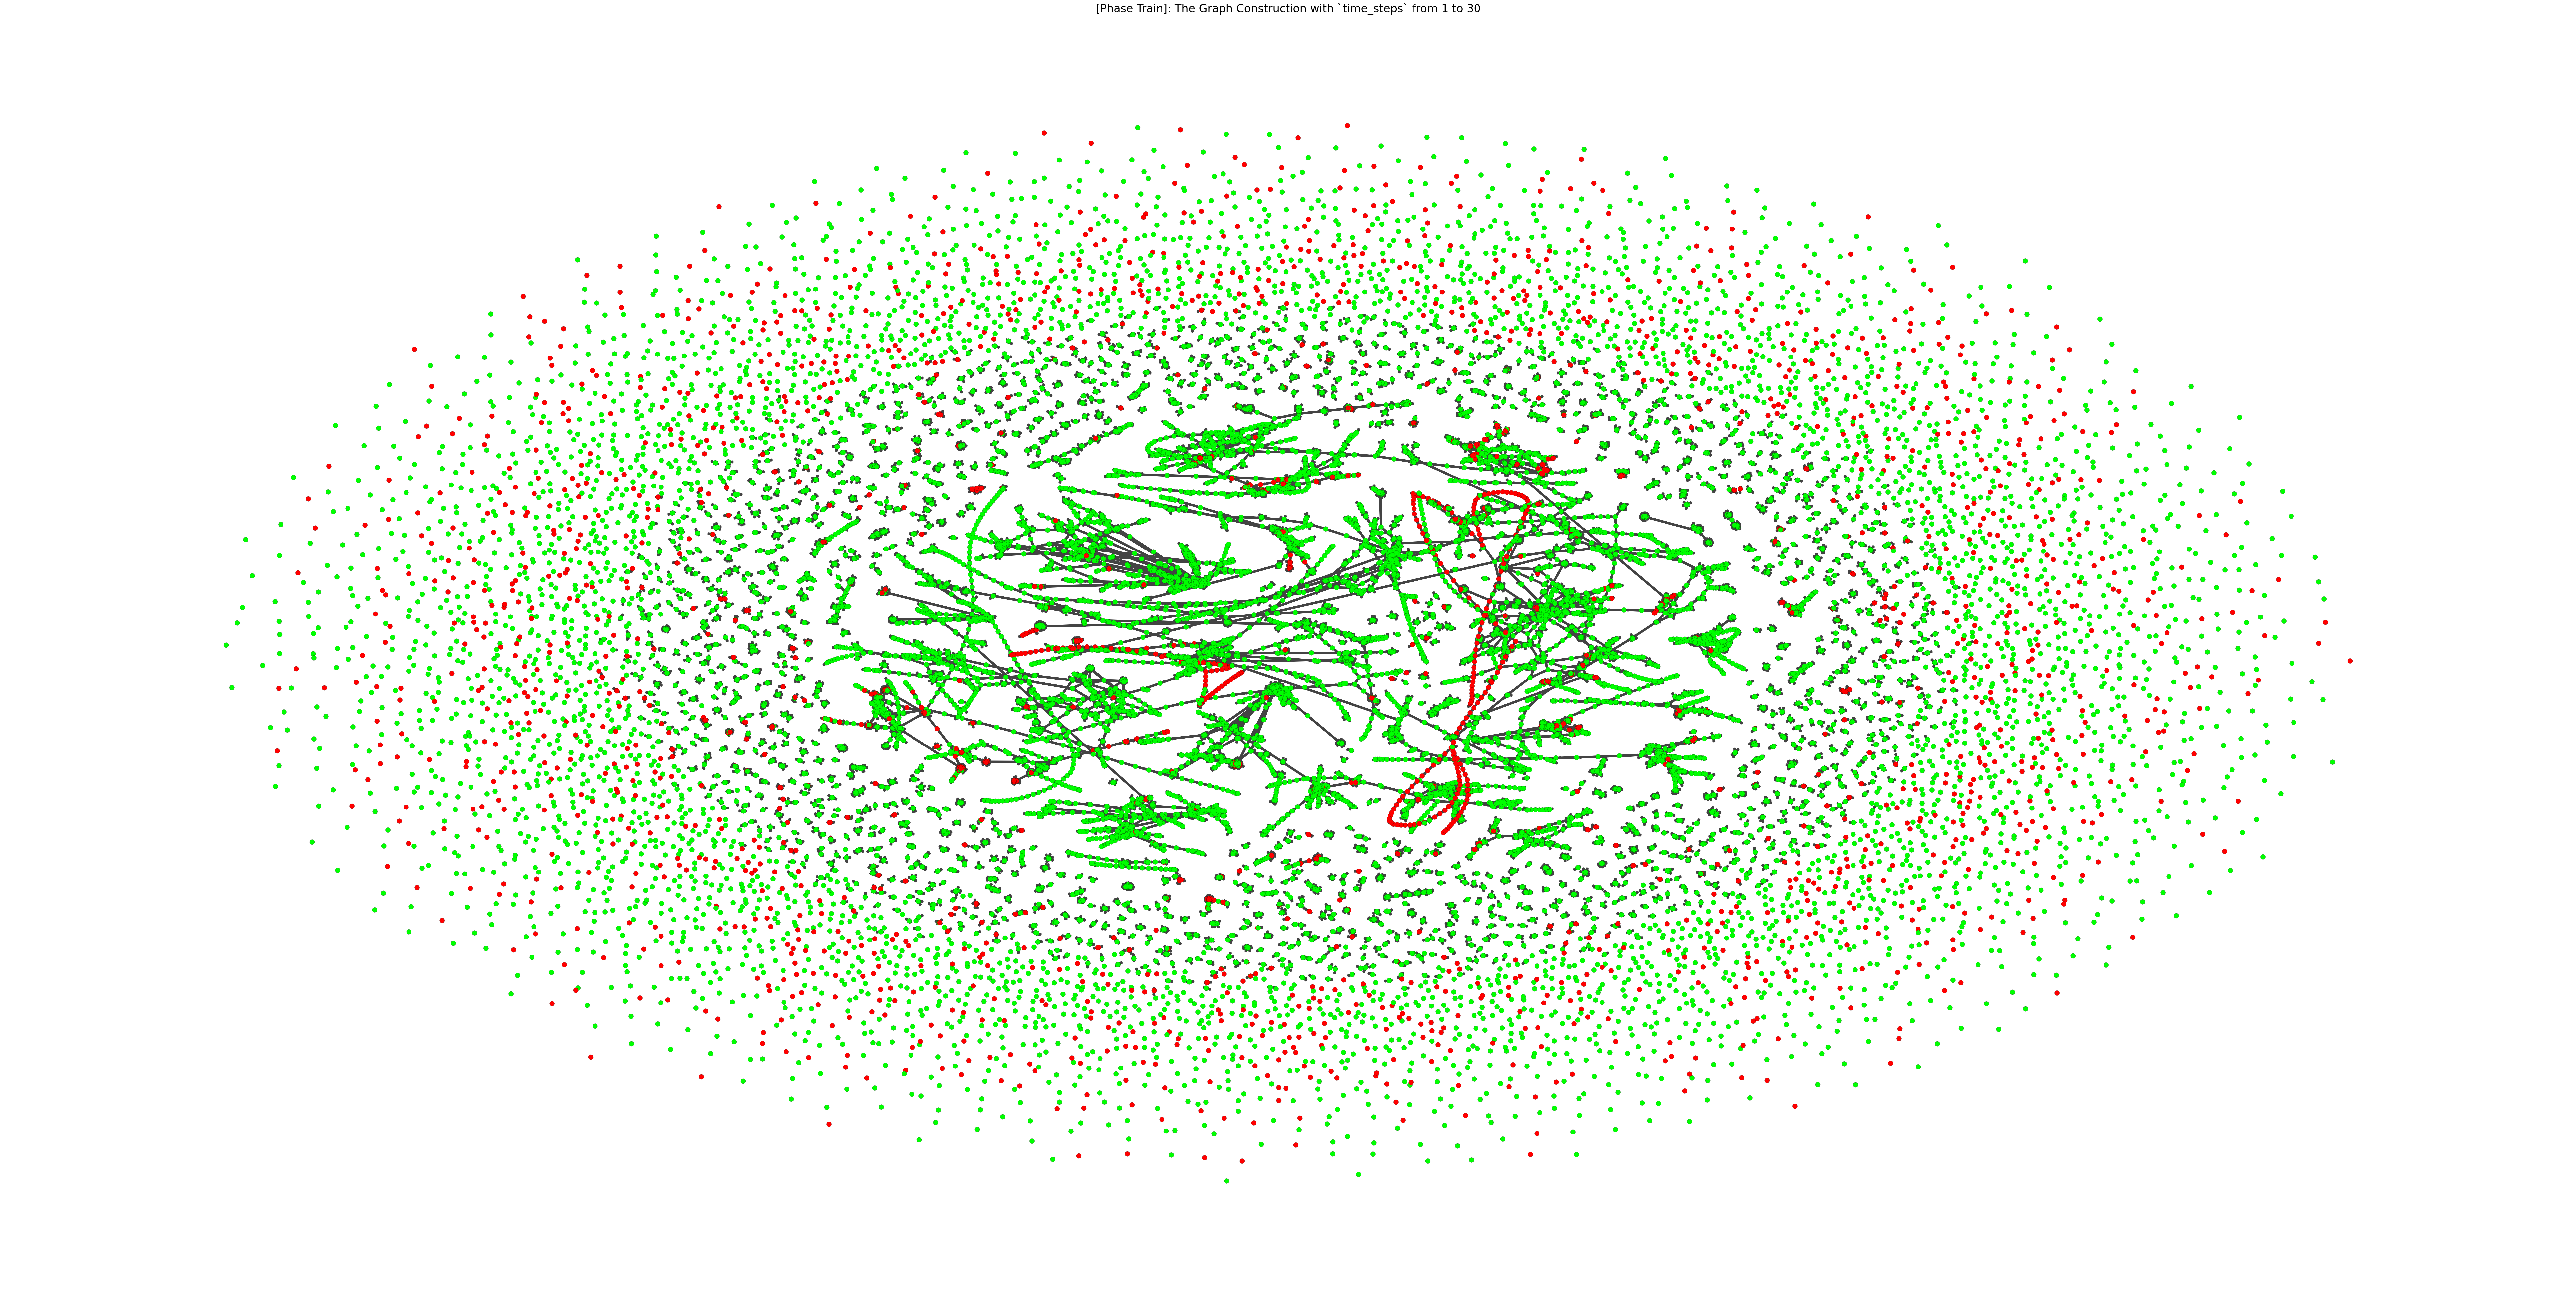

In [40]:
transid_by_ts = df_train.filter(
        pl.col('time_steps') == 28
).select(pl.col('transid')).to_series().to_list()

subv_list = list(edges_dict.values())
subgraph = tx_graph.induced_subgraph(subv_list)

layout = subgraph.layout('drl')

fig, ax = plt.subplots(figsize=(100, 50))
ax.set_title("[Phase Train]: The Graph Construction with `time_steps` from 1 to 30", fontsize=24)

ig.plot(subgraph, 
        vertex_size=15, 
        edge_arrow_size=5, 
        edge_arrow_width=2, 
        edge_width=5, 
        target=ax, 
        vertex_frame_width=0.2,
        layout=layout,
       )
